In [1047]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score

In [46]:
!pip install -q kaggle

In [47]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [49]:
!kaggle competitions download -c titanic

100%|███████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 220kB/s]
100%|███████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 219kB/s]


In [58]:
with zipfile.ZipFile('titanic.zip', 'r') as zip_ref:
    zip_ref.extractall('/Users/ipektufekcioglu/ML_PATH/datasets/titanic')

In [731]:
x_train = pd.read_csv("datasets/titanic/train.csv")

In [732]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [733]:
miss_col = x_train.isnull().sum()
miss_col

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [734]:
x_train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [1066]:
x_test = pd.read_csv("datasets/titanic/test.csv")

In [1067]:
test_dataset = x_test.copy()

In [911]:
y_train = x_train["Survived"]

In [737]:
y_train.shape

(891,)

In [738]:
#x_train = x_train.drop("Survived", axis=1)

In [739]:
numeric_cols = ["PassengerId", "Pclass", "Age", "SibSp", "Parch", "Fare"]

In [740]:
test_col = x_test.isnull().sum()
test_col

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [741]:
x_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [742]:
x_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Data Analysis

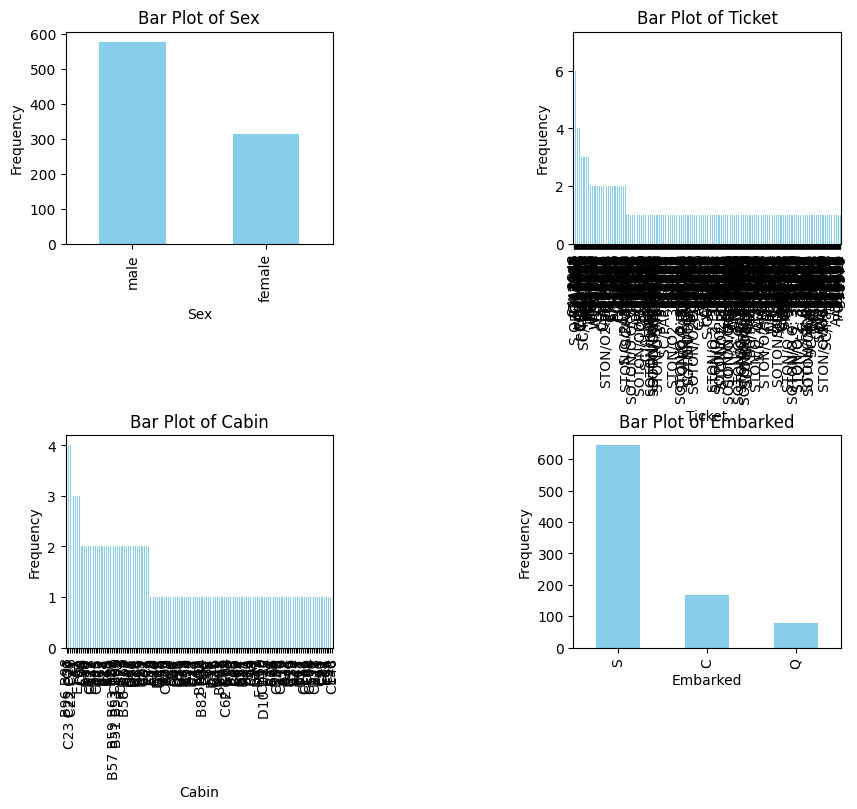

In [743]:
cats = ['Sex', 'Ticket', 'Cabin', 'Embarked']

plt.figure(figsize=(10, 8))  # Adjust figure size if needed
plt.subplots_adjust(wspace=0.9, hspace=0.9)
i = 0
for column in cats:
    plt.subplot(2,2,i+1)
    x_train[column].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Bar Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    i += 1
plt.show()

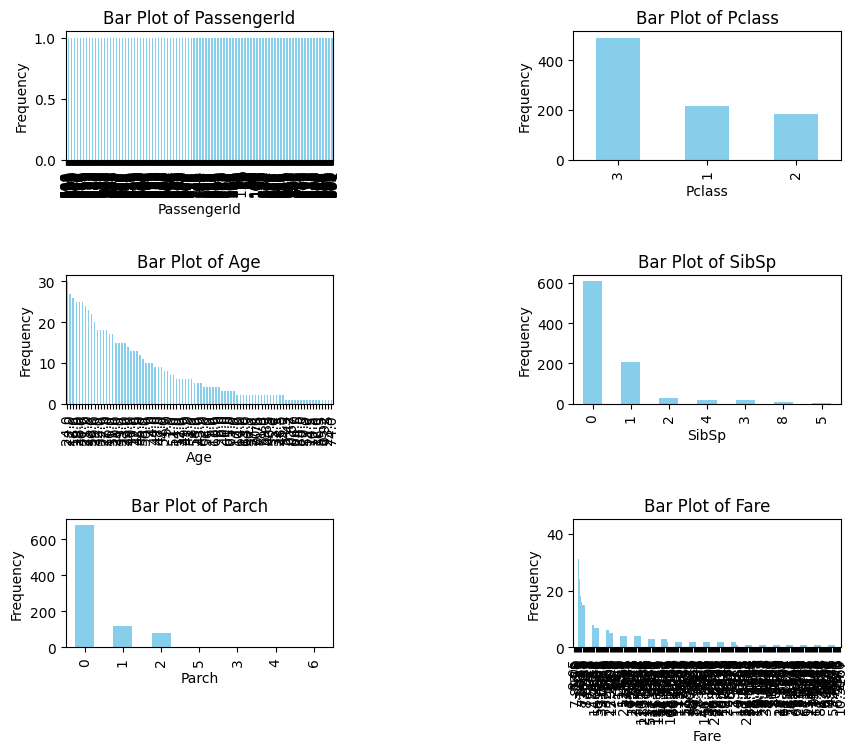

In [744]:
plt.figure(figsize=(10, 8))  # Adjust figure size if needed
plt.subplots_adjust(wspace=0.9, hspace=0.9)
i = 0
for column in numeric_cols:
    plt.subplot(3,2,i+1)
    x_train[column].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Bar Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    i += 1
plt.show()

In [838]:
#plots the passenger count that survived/not survived by teh given feature
def survival_by(x_train, feature):
    survival = x_train.groupby(["Survived", feature]).size().unstack()
    survival.plot(kind='bar')  # Orange for female, blue for male
    plt.title("Survival by {} on Titanic".format(feature))
    plt.xlabel("Survived")
    plt.ylabel("Passenger Count")
    plt.xticks(ticks=[0,1], labels=['No', 'Yes'], rotation=0)  # Labeling x-axis with 'No' and 'Yes'
    plt.legend(title=feature, labels= survival.columns)
    plt.show()

In [844]:
def survival_by_pie(x_train, feature):
    survival = x_train.groupby(feature)['Survived'].mean()
    plt.figure(figsize=(8, 6))
    plt.pie(survival, labels=survival.index, autopct='%1.1f%%', startangle=140)
    plt.title('Survival Rates by {} Groups'.format(feature))
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.show()

In [859]:
def survival_by_rate(x_train, feature):
    survival = x_train.groupby(feature)['Survived'].mean() * 100
    colors = plt.cm.tab10(np.linspace(0, 1, len(survival))) 
    plt.figure(figsize=(8, 6))
    bars = plt.bar(survival.index, survival.values, color=colors)
    plt.title('Survival Percentage by {} Groups'.format(feature))
    plt.xlabel('{} Groups'.format(feature))
    plt.ylabel('Survival Percentage')
    plt.ylim(0, 100)  # Set y-axis limit from 0 to 100 for percentage
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom')
    plt.show()

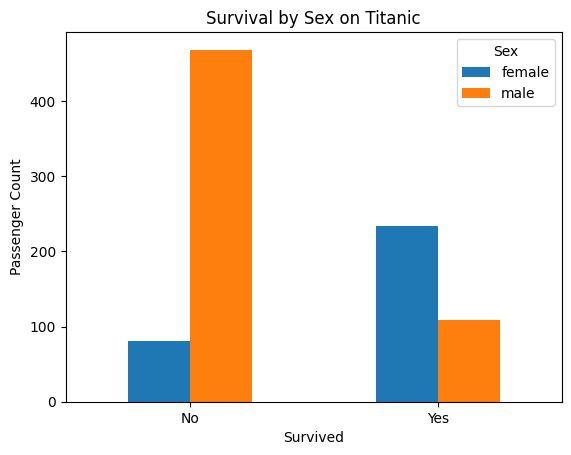

In [821]:
survival_by(x_train,"Sex")

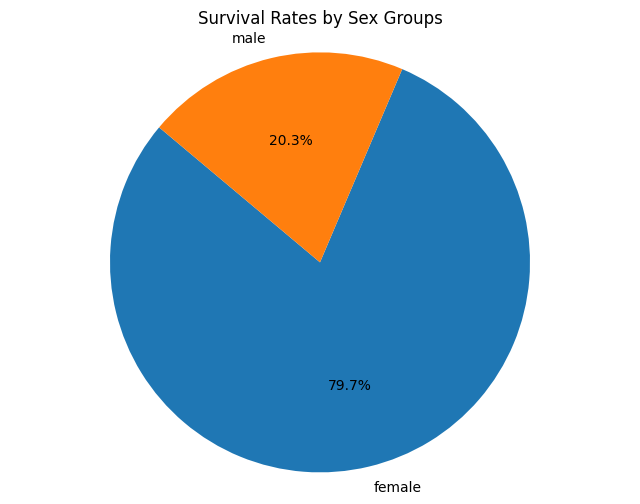

In [845]:
survival_by_pie(x_train,"Sex")

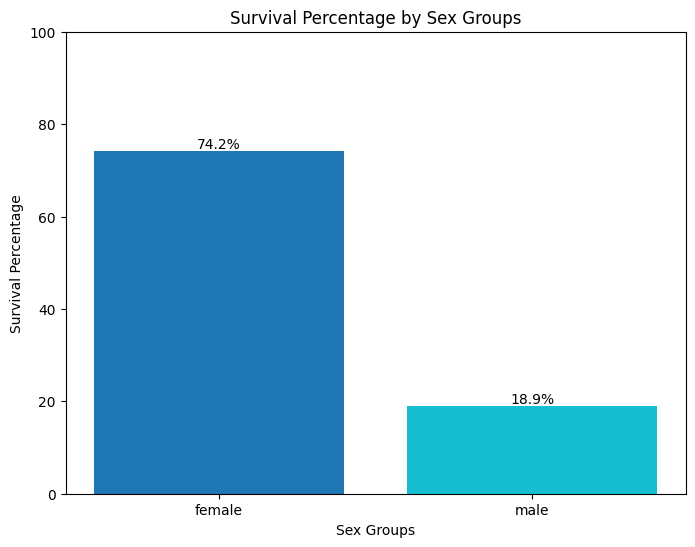

In [860]:
survival_by_rate(x_train, "Sex")

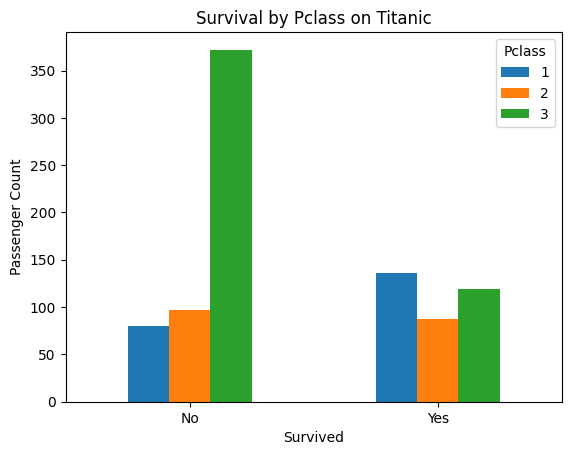

In [822]:
survival_by(x_train,"Pclass")

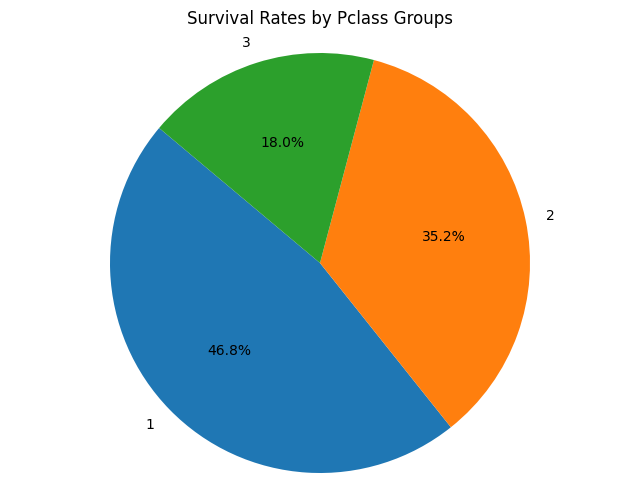

In [846]:
survival_by_pie(x_train,"Pclass")

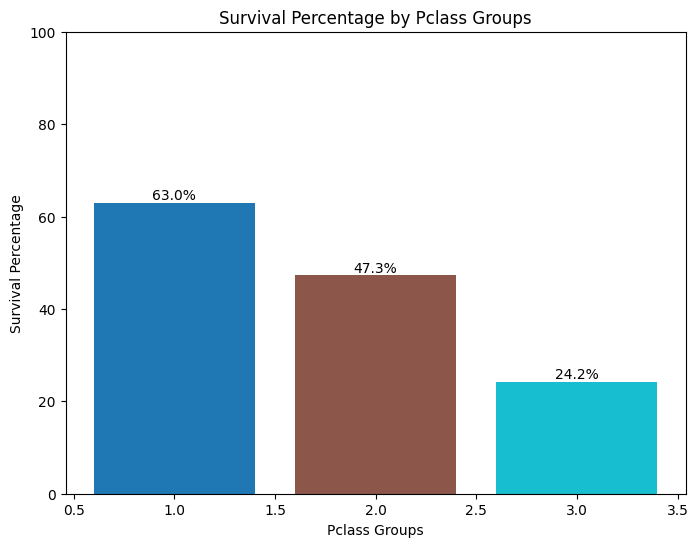

In [861]:
survival_by_rate(x_train,"Pclass")

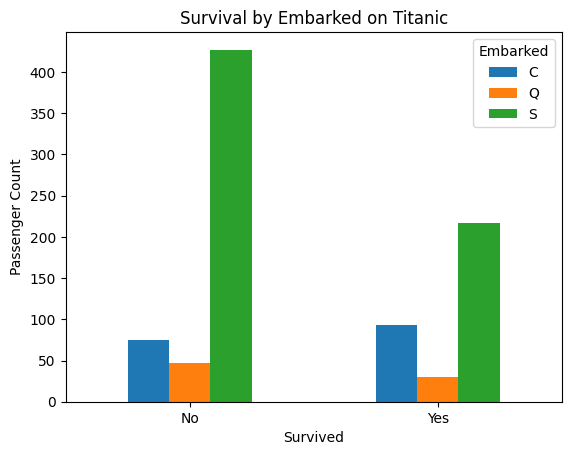

In [823]:
survival_by(x_train,"Embarked")

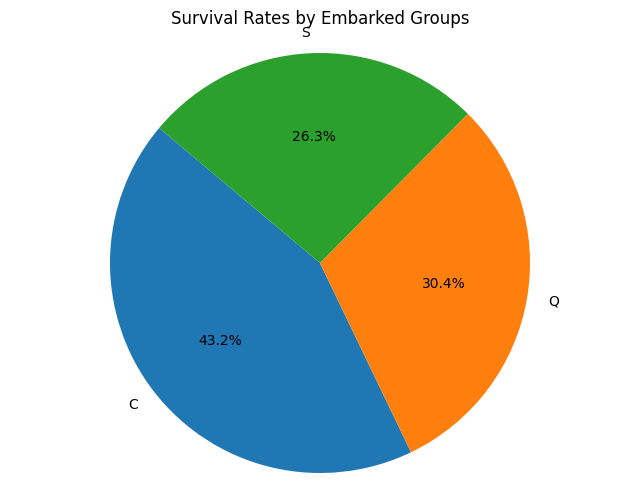

In [847]:
survival_by_pie(x_train,"Embarked")

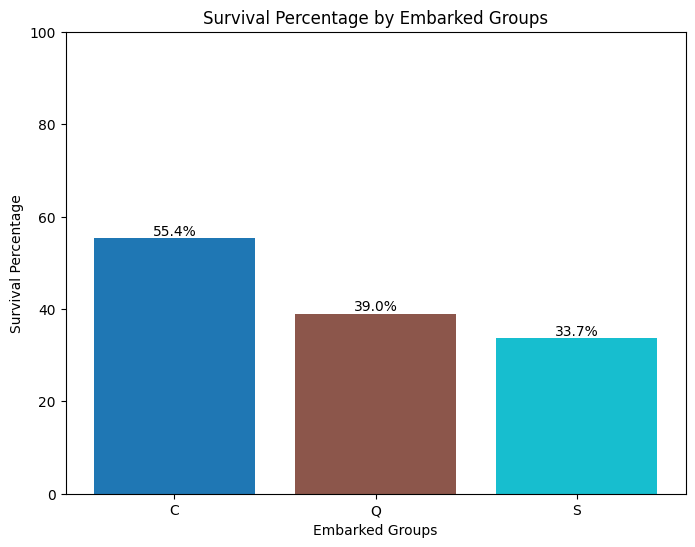

In [862]:
survival_by_rate(x_train,"Embarked")

/var/folders/bq/bmzh2t091596w5t8cnfgfjtm0000gn/T/ipykernel_6798/3211127208.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival = x_train.groupby(["Survived", feature]).size().unstack()


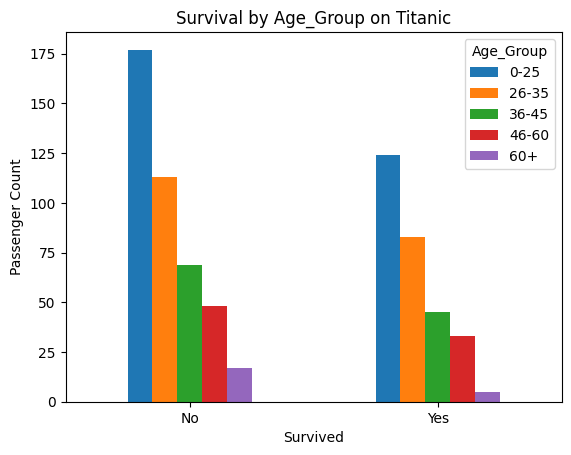

In [848]:
age_bins = [0,25,35,45,60, float("inf")]
bin_labels = ['0-25', '26-35', '36-45', '46-60', '60+']
x_train_copy = x_train.copy()
x_train_copy["Age_Group"] = pd.cut(x_train_copy['Age'], bins=age_bins, labels=bin_labels)
survival_by(x_train_copy,"Age_Group")

/var/folders/bq/bmzh2t091596w5t8cnfgfjtm0000gn/T/ipykernel_6798/1724568641.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival = x_train.groupby(feature)['Survived'].mean()


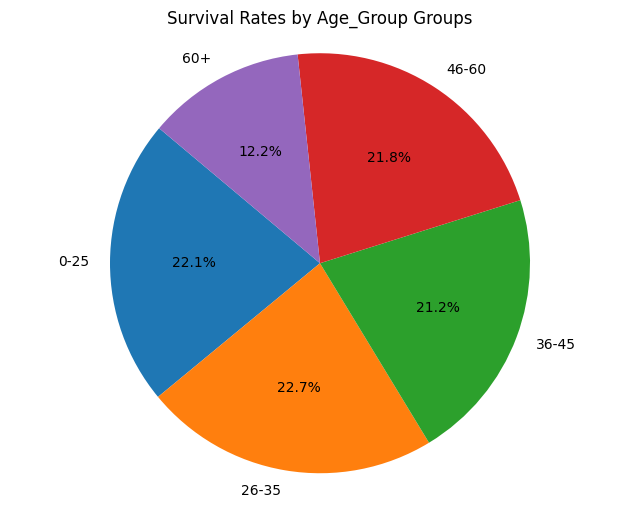

In [850]:
survival_by_pie(x_train_copy,"Age_Group")

/var/folders/bq/bmzh2t091596w5t8cnfgfjtm0000gn/T/ipykernel_6798/3737088968.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival = x_train.groupby(feature)['Survived'].mean() * 100


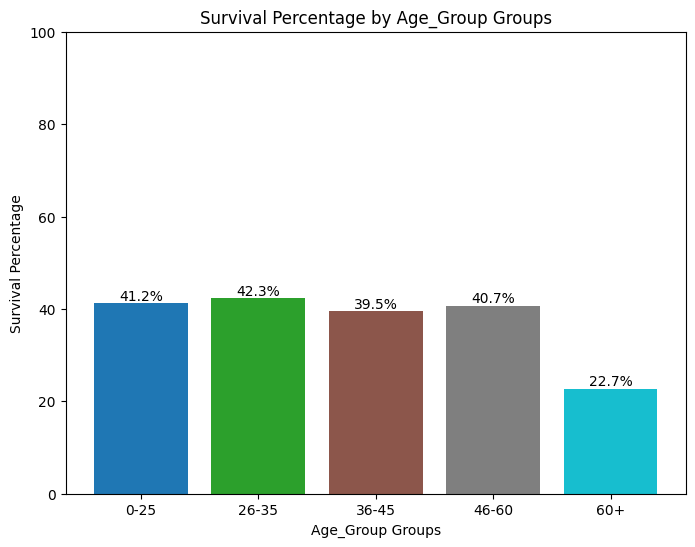

In [863]:
survival_by_rate(x_train_copy,"Age_Group")

In [865]:
x_train_copy = x_train.copy()
x_train_copy["Relative Number"] = x_train_copy["SibSp"] + x_train_copy["Parch"]

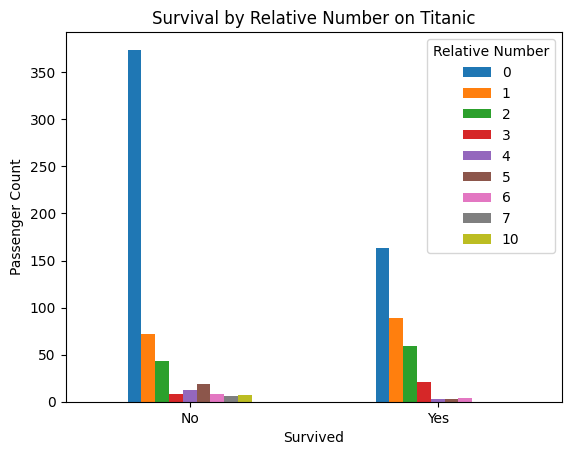

In [866]:
survival_by(x_train_copy, "Relative Number")

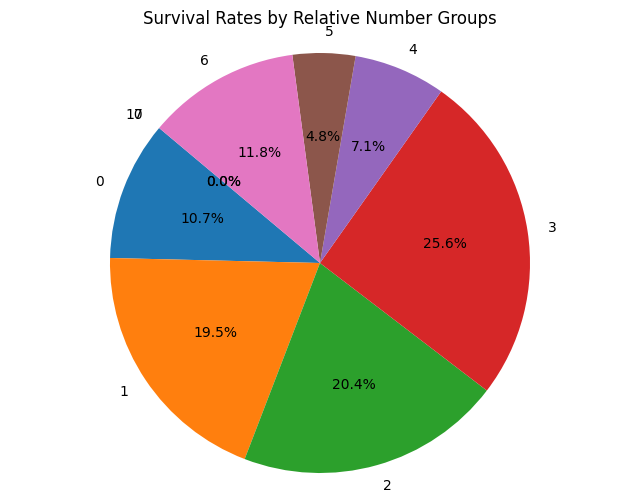

In [867]:
survival_by_pie(x_train_copy, "Relative Number")

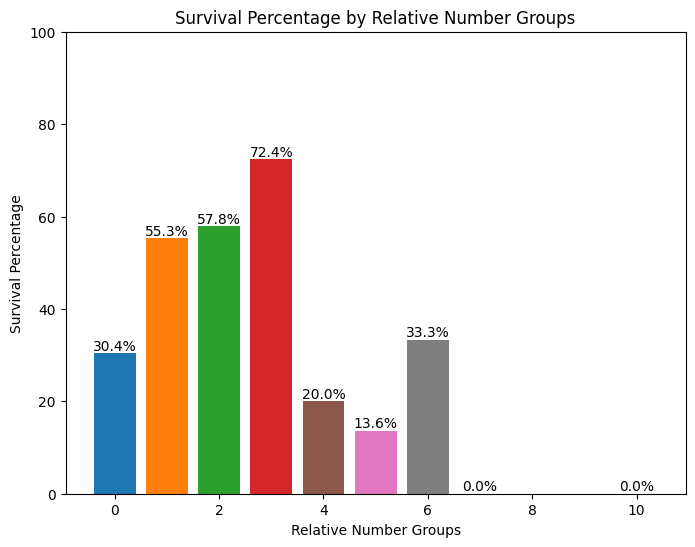

In [868]:
survival_by_rate(x_train_copy, "Relative Number")

/var/folders/bq/bmzh2t091596w5t8cnfgfjtm0000gn/T/ipykernel_6798/3211127208.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival = x_train.groupby(["Survived", feature]).size().unstack()


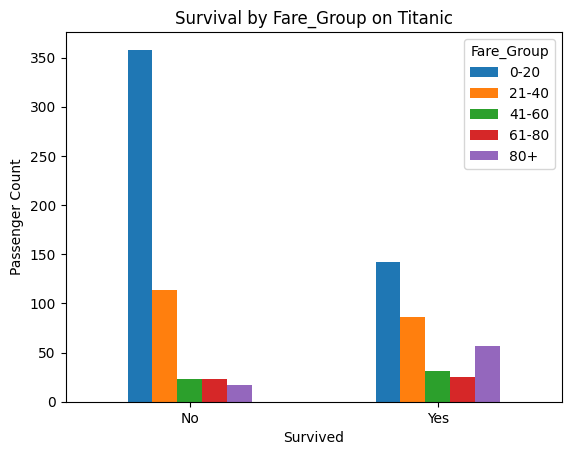

In [869]:
fare_bins = [0,20,40,60,80, float("inf")]
bin_labels = ['0-20', '21-40', '41-60', '61-80', '80+']
x_train_copy = x_train.copy()
x_train_copy["Fare_Group"] = pd.cut(x_train_copy['Fare'], bins=fare_bins, labels=bin_labels)
survival_by(x_train_copy, "Fare_Group")

/var/folders/bq/bmzh2t091596w5t8cnfgfjtm0000gn/T/ipykernel_6798/1724568641.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival = x_train.groupby(feature)['Survived'].mean()


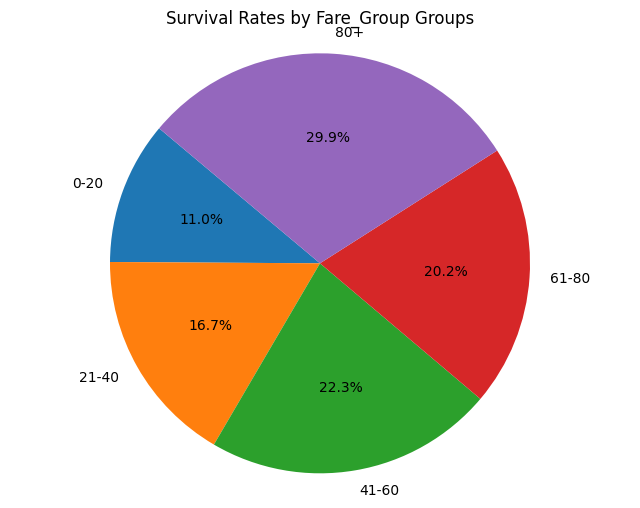

In [870]:
survival_by_pie(x_train_copy, "Fare_Group")

/var/folders/bq/bmzh2t091596w5t8cnfgfjtm0000gn/T/ipykernel_6798/3737088968.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival = x_train.groupby(feature)['Survived'].mean() * 100


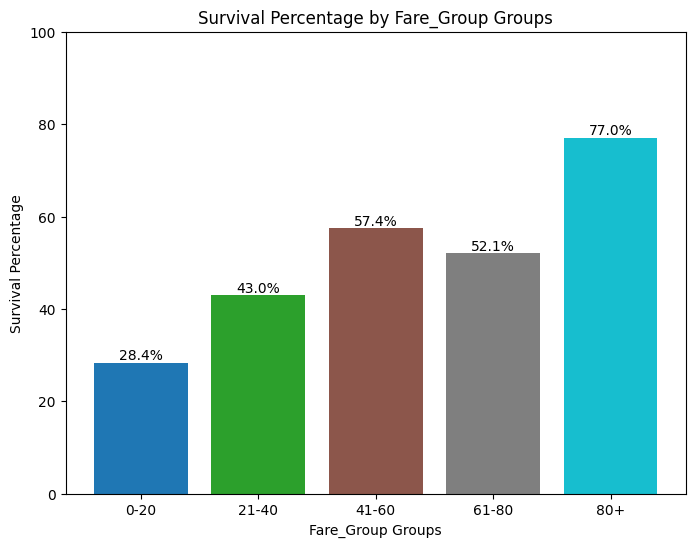

In [871]:
survival_by_rate(x_train_copy, "Fare_Group")

In [872]:
x_train_droped = x_train.drop(["Survived","PassengerId", "Cabin"], axis = 1)

In [873]:
x_test = x_test.drop(["PassengerId", "Cabin"], axis = 1)

In [874]:
mode_embarked = x_train_droped['Embarked'].mode()[0]  # Calculate the mode of 'Embarked'
x_train_droped['Embarked'].fillna(mode_embarked, inplace=True) 

In [875]:
mode_age = x_train_droped['Age'].mean()
x_train_droped['Age'].fillna(mode_age, inplace=True) 

In [876]:
x_test['Age'].fillna(mode_age, inplace=True) 

In [877]:
mode_fare = x_train_droped['Fare'].mean()
x_test['Fare'].fillna(mode_fare, inplace=True) 

In [878]:
x_train_droped.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [879]:
x_train_droped.isnull().sum()

Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

In [880]:
categorical_cols = ['Name', 'Sex', 'Ticket', 'Embarked']

In [881]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_categorical_cols = encoder.fit_transform(x_train_droped[categorical_cols])
encoded_categorical_cols_test = encoder.transform(x_test[categorical_cols])

In [882]:
feature_names = encoder.get_feature_names_out(categorical_cols)
feature_names

array(['Name_Abbing, Mr. Anthony', 'Name_Abbott, Mr. Rossmore Edward',
       'Name_Abbott, Mrs. Stanton (Rosa Hunt)', ..., 'Embarked_C',
       'Embarked_Q', 'Embarked_S'], dtype=object)

In [883]:
feature_names_test = encoder.get_feature_names_out(categorical_cols)
feature_names_test

array(['Name_Abbing, Mr. Anthony', 'Name_Abbott, Mr. Rossmore Edward',
       'Name_Abbott, Mrs. Stanton (Rosa Hunt)', ..., 'Embarked_C',
       'Embarked_Q', 'Embarked_S'], dtype=object)

In [884]:
encoded_df = pd.DataFrame(encoded_categorical_cols, columns=feature_names)
encoded_df.head()

,"Name_Abbing, Mr. Anthony","Name_Abbott, Mr. Rossmore Edward","Name_Abbott, Mrs. Stanton (Rosa Hunt)","Name_Abelson, Mr. Samuel","Name_Abelson, Mrs. Samuel (Hannah Wizosky)","Name_Adahl, Mr. Mauritz Nils Martin","Name_Adams, Mr. John","Name_Ahlin, Mrs. Johan (Johanna Persdotter Larsson)","Name_Aks, Mrs. Sam (Leah Rosen)","Name_Albimona, Mr. Nassef Cassem",...,Ticket_W./C. 14263,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [885]:
encoded_df_test = pd.DataFrame(encoded_categorical_cols_test, columns=feature_names_test)
encoded_df_test.head()

,"Name_Abbing, Mr. Anthony","Name_Abbott, Mr. Rossmore Edward","Name_Abbott, Mrs. Stanton (Rosa Hunt)","Name_Abelson, Mr. Samuel","Name_Abelson, Mrs. Samuel (Hannah Wizosky)","Name_Adahl, Mr. Mauritz Nils Martin","Name_Adams, Mr. John","Name_Ahlin, Mrs. Johan (Johanna Persdotter Larsson)","Name_Aks, Mrs. Sam (Leah Rosen)","Name_Albimona, Mr. Nassef Cassem",...,Ticket_W./C. 14263,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [886]:
encoded_df_test.shape

(418, 1577)

In [887]:
num_data = x_train_droped.drop(categorical_cols, axis = 1)
num_data = pd.concat([num_data, encoded_df], axis=1)
num_data.head()

,Pclass,Age,SibSp,Parch,Fare,"Name_Abbing, Mr. Anthony","Name_Abbott, Mr. Rossmore Edward","Name_Abbott, Mrs. Stanton (Rosa Hunt)","Name_Abelson, Mr. Samuel","Name_Abelson, Mrs. Samuel (Hannah Wizosky)",...,Ticket_W./C. 14263,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,38.0,1,0,71.2833,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,26.0,0,0,7.9250,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3,35.0,0,0,8.0500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [888]:
num_data_test = x_test.drop(categorical_cols, axis = 1)
num_data_test = pd.concat([num_data_test, encoded_df_test], axis=1)
num_data_test.head()

,Pclass,Age,SibSp,Parch,Fare,"Name_Abbing, Mr. Anthony","Name_Abbott, Mr. Rossmore Edward","Name_Abbott, Mrs. Stanton (Rosa Hunt)","Name_Abelson, Mr. Samuel","Name_Abelson, Mrs. Samuel (Hannah Wizosky)",...,Ticket_W./C. 14263,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3,47.0,1,0,7.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,62.0,0,0,9.6875,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,27.0,0,0,8.6625,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3,22.0,1,1,12.2875,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [889]:
num_data.shape

(891, 1582)

In [890]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(num_data)
scaled_data_test = scaler.fit_transform(num_data_test)

In [891]:
pca = PCA(n_components = 418)  # Specify the number of components to retain
pca_result = pca.fit_transform(scaled_data)
pca_result_test = pca.fit_transform(scaled_data_test)

In [894]:
selected_components = pca.explained_variance_ratio_

In [895]:
selected_components.sum()

1.0

In [896]:
pca.n_components_

418

In [897]:
columns = [f'PC{i+1}' for i in range(pca.n_components_)]  # Naming columns as PC1, PC2, etc.
transformed_df = pd.DataFrame(pca_result, columns=columns)

In [898]:
X_test = pd.DataFrame(pca_result_test, columns=columns)

In [899]:
transformed_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC409,PC410,PC411,PC412,PC413,PC414,PC415,PC416,PC417,PC418
0,-2.162734,0.709687,0.195691,0.882645,-0.257898,0.294049,2.232287,0.473638,0.954745,0.599256,...,1.108267,-1.908851,-2.815578,-2.088088,2.018919,2.147665,0.573360,1.617493,2.157895,0.834835
1,4.513784,-1.997810,-0.098366,-0.089299,-0.958895,-0.886347,1.127130,-1.151681,-0.810647,0.679964,...,3.249819,0.773532,-0.836700,7.765411,0.364877,-0.890026,0.172454,0.376825,1.593321,-2.568563
2,0.297776,1.749556,0.663904,-2.931851,-2.614754,0.224129,1.892267,1.215609,0.214855,-0.235851,...,-1.871413,0.113915,-0.093857,0.213929,-0.162600,-1.684274,-0.342210,0.370673,1.061298,-2.028317
3,1.653566,0.602387,-1.782594,-2.089488,0.623947,-0.299610,1.263359,-1.568789,0.580367,-0.821293,...,0.691770,0.239280,1.053889,-0.255238,-2.687845,-0.643025,-1.749951,0.725988,0.448526,0.012435
4,-2.343701,-0.194791,-0.259115,-0.182497,-0.130252,-1.008215,-0.714234,1.495023,-0.371816,-2.469867,...,0.454666,-0.057924,-1.422047,-0.331116,-1.262836,-1.949099,-0.142802,-0.047732,-0.467953,-0.778233


In [900]:
X_test.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC409,PC410,PC411,PC412,PC413,PC414,PC415,PC416,PC417,PC418
0,-1.460858,-1.971552,2.915886,1.157393,5.191648,3.012875,2.156136,-1.193365,-0.116251,-0.117870,...,-2.322141e-18,7.125106e-18,4.016097e-18,1.011347e-17,2.467679e-18,-2.727490e-18,-2.861178e-18,-4.339708e-18,-1.155525e-18,-5.900836e-19
1,0.019155,1.169948,0.536210,-1.025688,0.381227,-0.829798,0.018339,0.513459,0.003344,0.002027,...,-1.022483e-16,2.299886e-16,2.051122e-16,-1.782904e-16,-7.771601e-17,-6.585475e-17,1.191806e-16,6.719536e-17,8.540145e-17,-8.295097e-18
2,0.048964,-1.785545,1.063896,-0.206908,2.402322,0.150486,0.893457,-0.336329,0.001142,0.001269,...,1.850895e-16,1.357649e-16,1.214091e-16,-1.783170e-16,-5.216104e-17,5.512537e-17,-2.276675e-17,-5.041798e-17,2.506056e-17,2.941844e-18
3,-1.583249,-0.518566,-0.303032,-0.283535,-0.191165,0.132825,0.101665,0.255941,0.000874,0.000208,...,-2.926119e-16,-6.476006e-17,-4.513583e-17,-8.292357e-17,-3.696286e-17,-1.892946e-17,-2.796686e-17,-2.255853e-17,7.001371e-18,7.508768e-18
4,-0.531645,3.202013,0.967471,-0.554857,-0.855525,-0.778046,-0.385892,1.661989,0.159058,0.238040,...,-2.322141e-18,7.125106e-18,4.016097e-18,1.011347e-17,2.467679e-18,-2.727490e-18,-2.861178e-18,-4.339708e-18,-1.155525e-18,-5.900836e-19


In [901]:
transformed_df.shape

(891, 418)

In [908]:
X_test.shape

(418, 418)

In [909]:
y_train.shape

(712,)

In [912]:
X_train, X_val, y_train, y_val = train_test_split(transformed_df, y_train, test_size=0.2, stratify= y_train, random_state=42)

In [913]:
X_train.shape

(712, 418)

In [914]:
X_val.shape

(179, 418)

# XGBOOST CLASSIFIER

In [916]:
param_grid = {
    "learning_rate": [0.1, 0.01, 0.001],
    "reg_alpha": [0.1, 0.5, 1.0],
    "reg_lambda": [0.1, 0.5, 1.0],
    "n_estimators": [100, 200],
    "max_depth": [3, 5, None]
}

grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, m...
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, None], 'n_estimators': [100, 200],
                         'reg_alpha': [0.1, 0.5, 1.0],
                         'reg_lambda': [0.1, 0.5, 1.0]},
             scoring='accuracy')

In [918]:
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 1.0, 'reg_lambda': 1.0}


In [919]:
xgb_classifier.set_params(learning_rate = 0.1, reg_alpha=1.0, 
                          reg_lambda=1.0, n_estimators = 200,
                         max_depth = 3)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [920]:
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [921]:
cv_scores = cross_val_score(xgb_classifier, X_train, y_train, cv=15, scoring="accuracy")

In [922]:
cv_scores

array([0.72916667, 0.8125    , 0.79166667, 0.85416667, 0.6875    ,
       0.8125    , 0.83333333, 0.85106383, 0.89361702, 0.87234043,
       0.82978723, 0.80851064, 0.80851064, 0.82978723, 0.74468085])

In [923]:
val_score = xgb_classifier.score(X_val, y_val)

In [924]:
val_score

0.7430167597765364

# Random Forest

In [927]:
model_rf = RandomForestClassifier(random_state=42)

In [937]:
param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, None],
    "min_samples_split": [2, 5, 10]
}

In [938]:
grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf, cv=5, scoring="accuracy")
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=200,
                                              random_state=42),
             param_grid={'max_depth': [3, 5, None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [939]:
rf_best_params = grid_search_rf.best_params_
print("Best parameters for Random Forest:", rf_best_params)

Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [940]:
model_rf.set_params(max_depth = None, min_samples_split = 2, n_estimators = 200)

RandomForestClassifier(n_estimators=200, random_state=42)

In [941]:
model_rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [942]:
rf_cross_val = cross_val_score(model_rf, X_train, y_train, cv=10, scoring="accuracy")

In [943]:
rf_cross_val

array([0.66666667, 0.68055556, 0.74647887, 0.74647887, 0.74647887,
       0.77464789, 0.81690141, 0.70422535, 0.76056338, 0.76056338])

In [944]:
val_score_rf = model_rf.score(X_val, y_val)

In [945]:
val_score_rf

0.6759776536312849

# Support Vector Machines

In [946]:
model_svm = SVC(random_state=42)

In [958]:
param_grid_svc = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"]
}

In [959]:
grid_search_svc = GridSearchCV(estimator = model_svm, param_grid = param_grid_svc, cv = 5, scoring="accuracy")

In [960]:
grid_search_svc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [961]:
svc_best_params = grid_search_svc.best_params_
print("Best parameters for SVM:", svc_best_params)

Best parameters for SVM: {'C': 10, 'kernel': 'rbf'}


In [1033]:
model_svm.set_params(C = 10, kernel = "rbf")

SVC(C=10, probability=True, random_state=42)

In [1034]:
model_svm.fit(X_train,y_train)

SVC(C=10, probability=True, random_state=42)

In [1035]:
svc_cross_val = cross_val_score(model_svm, X_train, y_train, cv=10, scoring="accuracy")

In [1029]:
svc_cross_val

array([0.76388889, 0.80555556, 0.8028169 , 0.78873239, 0.81690141,
       0.84507042, 0.83098592, 0.76056338, 0.77464789, 0.74647887])

In [1030]:
val_score_svc = model_svm.score(X_val, y_val)

In [1031]:
val_score_svc

0.770949720670391

# Logistic Regression

In [974]:
model_lr = LogisticRegression(random_state=42)

In [984]:
param_grid_lr = {
    "C": [0.1, 1, 10],
    "penalty": ["l1","l2", "elasticnet"],
    "solver": ["liblinear", "lbfgs", "saga"]
}

In [985]:
grid_search_lr = GridSearchCV(estimator = model_lr, param_grid = param_grid_lr, cv = 5, scoring = "accuracy")

In [986]:
grid_search_lr.fit(X_train, y_train)

/Users/ipektufekcioglu/ML_PATH/my_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ipektufekcioglu/ML_PATH/my_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ipektufekcioglu/ML_PATH/my_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ipektufekcioglu/ML_PATH/my_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ipektufekcioglu/ML_PATH/my_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 1, 10],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['liblinear', 'lbfgs', 'saga']},
             scoring='accuracy')

In [987]:
lr_best_params = grid_search_lr.best_params_

In [988]:
print("Best parameters for Logistic Regression:", lr_best_params)

Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}


In [989]:
model_lr.set_params(C = 0.1, penalty = "l1", solver = "saga")

LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')

In [990]:
model_lr.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')

In [991]:
lr_cross_val = cross_val_score(model_lr, X_train, y_train, cv=10, scoring="accuracy")

In [992]:
lr_cross_val

array([0.77777778, 0.77777778, 0.76056338, 0.69014085, 0.87323944,
       0.81690141, 0.81690141, 0.8028169 , 0.81690141, 0.8028169 ])

In [993]:
lr_val_score = model_lr.score(X_val, y_val)

In [994]:
lr_val_score

0.776536312849162

In [1036]:
voting = VotingClassifier(
    estimators=[("xgb", xgb_classifier),("rf", model_rf), ("svm", model_svm), ("lr", model_lr)],
    voting="hard"  # 'hard' for majority voting or 'soft' for probabilities voting
)

In [1037]:
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('rf',
                              RandomForestClassifier(n_estimators=200,
                                                     random_state=42)),
                             ('svm',
                              SVC(C=10, probability=True, random_state=42)),
                             ('lr',
                              LogisticRegression(C=0.1, penalty='l1',
                                                 random_state=42,
                                                 solver='saga'))])

In [1038]:
voting_val_score = voting.score(X_val, y_val)

In [1039]:
voting_val_score

0.7653631284916201

# AdaBoost

In [1048]:
weighted_predictions = 0
weights_sum = 0

for model in [xgb_classifier, model_rf, model_svm, model_lr]:
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    
    accuracy = accuracy_score(y_val, predictions)
    print(f"Accuracy of {type(model).__name__}: {accuracy:.4f}")

    weighted_predictions += predictions
    weights_sum += accuracy

Accuracy of XGBClassifier: 0.7430
Accuracy of RandomForestClassifier: 0.6760
Accuracy of SVC: 0.7709
Accuracy of LogisticRegression: 0.7765


In [1049]:
final_predictions = (weighted_predictions / weights_sum).astype(int)

In [1051]:
final_accuracy = accuracy_score(y_val, final_predictions)

In [1052]:
final_accuracy

0.7653631284916201

In [995]:
models = [xgb_classifier, model_rf, model_svm, model_lr]  # List of models

for model in models:
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    val_scores = model.score(X_val, y_val)
    print(f"{type(model).__name__} - Cross-validation scores:", cv_scores)
    print(f"Mean accuracy: {cv_scores.mean():.4f} (± {cv_scores.std():.4f})")
    print(f"{type(model).__name__} - Validation scores:", val_scores)



XGBClassifier - Cross-validation scores: [0.78321678 0.81118881 0.83802817 0.82394366 0.80985915]
Mean accuracy: 0.8132 (± 0.0181)
XGBClassifier - Validation scores: 0.7430167597765364
RandomForestClassifier - Cross-validation scores: [0.68531469 0.73426573 0.73239437 0.75352113 0.78169014]
Mean accuracy: 0.7374 (± 0.0315)
RandomForestClassifier - Validation scores: 0.6759776536312849
SVC - Cross-validation scores: [0.79020979 0.76223776 0.82394366 0.78873239 0.75352113]
Mean accuracy: 0.7837 (± 0.0247)
SVC - Validation scores: 0.770949720670391
LogisticRegression - Cross-validation scores: [0.76223776 0.72727273 0.82394366 0.8028169  0.80985915]
Mean accuracy: 0.7852 (± 0.0355)
LogisticRegression - Validation scores: 0.776536312849162


# Predictions

In [1065]:
x_test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,3,"Kelly, Mr. James",male,34.500000,0,0,330911,7.8292,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,363272,7.0000,S
2,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,240276,9.6875,Q
3,3,"Wirz, Mr. Albert",male,27.000000,0,0,315154,8.6625,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,3101298,12.2875,S
...,...,...,...,...,...,...,...,...,...
413,3,"Spector, Mr. Woolf",male,29.699118,0,0,A.5. 3236,8.0500,S
414,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C
415,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,S
416,3,"Ware, Mr. Frederick",male,29.699118,0,0,359309,8.0500,S


In [1008]:
def predict_model(model):
    predictions = model.predict(X_test)
    predictions = pd.DataFrame(predictions)
    predictions.columns = ["Survived"]
    predictions_set = pd.concat([test_dataset["PassengerId"], predictions], axis = 1)
    return predictions_set

In [1001]:
predictions_xgb = predict_model(xgb_classifier)

In [1002]:
predictions_xgb.to_csv("titanic_xgb_predictions.csv", index = False)

In [1003]:
predictions_rf = predict_model(model_rf)

In [1004]:
predictions_rf.to_csv("titanic_rf_predictions.csv", index = False)

In [999]:
predictions_svm = predict_model(model_svm)

In [1000]:
predictions_svm.to_csv("titanic_svm_predictions.csv", index = False)

In [1009]:
predictions_lr = predict_model(model_lr)

In [1011]:
predictions_lr.to_csv("titanic_lr_predictions.csv", index = False)

In [1018]:
predictions_voting = predict_model(voting)

In [1019]:
predictions_voting.to_csv("titanic_voting_predictions.csv", index = False)

In [1074]:
weighted_predictions_test = 0
weights_sum_test = 0

# Apply models sequentially and make weighted predictions on unseen data
for model in [xgb_classifier, model_rf, model_svm, model_lr]:
    predictions_test = model.predict(X_test)
    
    weighted_predictions_test += predictions_test
    weights_sum_test += 1  # Assuming equal weight for each model on unseen data

final_predictions_test = (weighted_predictions_test / weights_sum_test).astype(int)
final_predictions_test = pd.DataFrame(final_predictions_test)
final_predictions_test.columns = ["Survived"]
predictions_adaboost = pd.concat([test_dataset["PassengerId"], final_predictions_test], axis = 1)

In [1075]:
predictions_adaboost.to_csv("titanic_adaboost_predictions.csv", index = False)

In [1076]:
!kaggle competitions submit -c titanic -f titanic_adaboost_predictions.csv -m "Adaboost"

100%|██████████████████████████████████████| 2.77k/2.77k [00:00<00:00, 3.01kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster